### Notebook 3. Supplementary: Temperature Forecasting using RNN

Compiled by:
Christopher Monterola

Lecture is taken from:

**1. Python Machine Learning, Second Edition, Sebastian Raschka and Vahid Mirjalili, Packt Publishing Ltd. Birmingham B3 2PB, UK Sept 2017.**

**2. Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurélien Géron, O'Reilly 2017.**

**3. Deep Learning with Python, Francois Chollet, Manning New York 2018.**

In this notebook, we will continue in illustrating RNN by using it to  work on the following: **Temperature forecasting problem [reference 3]**    


 In the next example, we’ll review three advanced techniques for improving the performance and generalization power of recurrent neural networks.  We’ll demonstrate all three concepts on a temperature-forecasting problem, where you have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which you use to predict what the temperature will be 24 hours after the last data point. 

This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries. We’ll cover the following techniques:

 GRU based architecture in contrast with simple RNN and LSTM 
 Recurrent dropout—This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.    
 Stacking recurrent layers—This increases the representational power of the network (at the cost of higher computational loads).    


### Example 2:  Temperature forecasting problem

Sequence data is found in diverse problems other than just language processing. In all the examples in this section, you’ll play with a weather timeseries dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany. In this dataset, 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. This dataset is perfect for learning to work with numerical timeseries. You’ll use it to build a model that takes as input some data from the recent past (a few days’ worth of data points) and predicts the air temperature 24 hours in the future.

Here are the actual variables in the data:

Date Time   
p (mbar) atmospheric pressure  
T (degC) temperature  
Tpot (K) potential temperature  
Tdew (degC) dew point temperature  
rh (%) relative humidity  
VPmax (mbar) saturation water vapor pressure  
VPact (mbar) actual water vapor pressure  
VPdef (mbar) water vapor pressure deficit  
sh (g/kg) specific humidity  
H2OC (mmol/mol) water vapor concentration  
rho (g/$m^3$) air density  
wv (m/s) wind velocity  
max. wv (m/s) maximum wind velocity  
wd (deg) wind direction  


### Step 1: Get the data

Download and uncompress the data as follows:

Let’s look at the data.

### Inspecting the data of the Jena weather dataset

In [94]:
import os
#data_dir = '/home/cmonterola/Desktop/JourneyBack/DeepLearning/'
fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [95]:
import pandas as pd

data2 = pd.read_csv('jena_climate_2009_2016.csv')
dummy=data2
dummy.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Now, convert all 420,551 lines of data into a Numpy array.

In [96]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [32]:
float_data.shape

(420551, 14)

### Step 2: Visualize by plotting the temperature timeseries

You can clearly see the yearly periodicity of temperature.

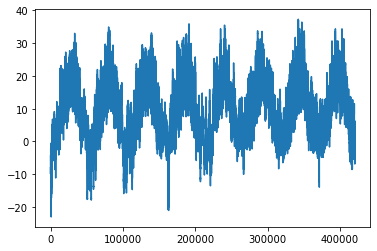

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  #temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

Below is a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, you get 144 data points per day.

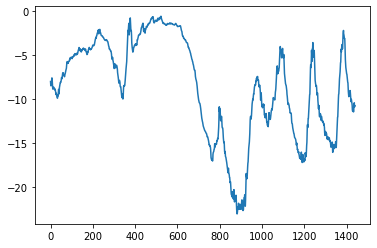

In [34]:
plt.plot(range(1440), temp[:1440])

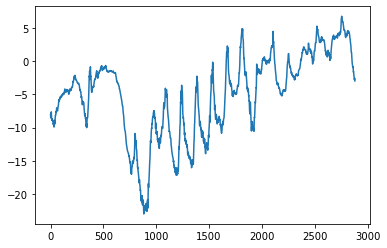

In [35]:
plt.plot(range(2880), temp[:2880])

On this plot, you can see daily periodicity, especially evident for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month. If you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity
of the data. 

But looking at the data over a scale of days, the temperature looks a lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out. Shown below are plots for 100 days ($2880*5$) and 200 days ($2880*10$)

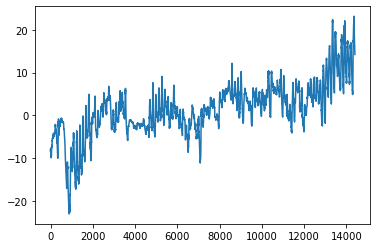

In [36]:
plt.plot(range(2880*5), temp[:2880*5])

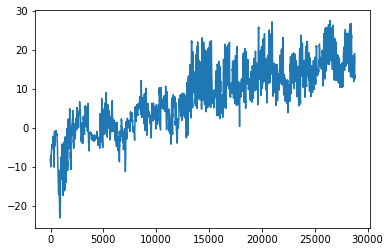

In [37]:
plt.plot(range(2880*10), temp[:2880*10])

### Step 3. Preparing the data

The exact formulation of the problem will be as follows: given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can you predict the temperature in delay timesteps? 

You’ll use the following parameter values:

 lookback = 1440—Observations will go back 10 days (10 days $\times$ 144 timesteps/day).   
 steps = 6—Observations will be sampled at one data point per hour.   
 delay = 144—Targets will be 24 hours in the future.   

Meaning the total number of inputs is 720/6 = 120 and the forecast every hour is for 24 data points. Hence, this is a many to many forecasting.

<img src="FeedforwardNN_timeseries.png" width="800">
<img src="RNNGRULSTM_timeseries.png" width="800">

To get started, you need to do two things:

 **A. Normalization**: Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each time series in the data is on a different scale (for example, temperature is typically between -20 and +30 celsius, but atmospheric pressure, measured in mbar, is around 1,000). You’ll normalize each timeseries independently so that they all take small values on a similar scale.    

 **B. Sampling**: Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you’ll generate the samples on the fly using the original data.   

You’ll preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. You’re going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation only on this fraction of the data.



### Step 3A. Normalize the data:

In [97]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Listed in the code below are the data generator function you’ll use. It yields a tuple (samples, targets), where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:
    
 data—The original array of floating-point data, which you normalized above.  
 lookback—How many timesteps back the input data should go.  
 delay—How many timesteps in the future the target should be.  
 min_index and max_index—Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.  
 shuffle—Whether to shuffle the samples or draw them in chronological order.  
 batch_size—The number of samples per batch.  
 step—The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw one data point every hour. note that the number of inputs = lookback/step  

### Step 3B. Sampling the data: Generator yielding timeseries samples and their targets

In [98]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

### Step 3B. Sampling the data: Preparing the training, validation, and test generation

In [99]:
lookback = 1440
step = 6
delay = 144
batch_size = 128 #Each of the batch will have inputs = lookback/step (240 hours in this example) +  delay/step (24 hours)  

train_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

test_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)  #How many steps to draw from val_gen in order to see the entire 
                                          #validation set --- 
                                         #This is normally a problem in keras so let's manually set this to just 1000
test_steps = (len(float_data) - 300001 - lookback)  #How many steps to draw from test_gen in order to see the 
                                          #entire test set 

### Step 4. Understand the baseline

### Baseline Error

Before you start using black-box deep-learning models to solve the temperatureprediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that you’ll have to beat in order to demonstrate the usefulness of more-advanced machine-learning models. Such common-sense baselines can be useful when you’re approaching a new problem for which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes are much more common than others. If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to
the classification task is to always predict “A” when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. 

Sometimes, such elementary baselines can prove surprisingly hard to beat.   

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to always predict that the temperature 24 hours from now will be equal to the temperature right now.

*Today essentially is the same as yesterday.*

Let’s evaluate this approach, using the mean absolute error (MAE = $\sum_{i=1}^{N} \frac{|Theoretical_i - Actual_i|}{N} = \sum_{i=1}^{N} \frac{|error_i|}{N}$) metric: *np.mean(np.abs(preds - targets))*

In [41]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

0.28969941979609765


In [42]:
std[1]

8.85249908220462

This yields an MAE of 0.29. Because the temperature data has been normalized to be centered on 0 and have a standard deviation of 1, this number isn’t immediately interpretable. It translates to an average absolute error of 0.29 × temperature_std degrees Celsius: 2.57°C.

In [43]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

That’s a fairly large average absolute error. Now the game is to use your knowledge of
deep learning to do better.

### Baseline model: Simple Neural Networks

In the same way that it’s useful to establish a common-sense baseline before trying machine-learning approaches, it’s useful to try simple, cheap machine-learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any
further complexity you throw at the problem is legitimate and delivers real benefits. The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. You use MAE as the loss.

Because you evaluate on the exact same data and with the exact same metric you did with the common-sense approach, the results will be directly comparable.

In [47]:
val_steps

98559

In [48]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500, #ideally steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                              epochs=20,
                              validation_data=val_gen, 
                              validation_steps=1000) #ideally validation_steps = TotalvalidationSamples / ValidationBatchSize

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
500/500 [==============================] - 9s 19ms/step - loss: 1.3114 - val_loss: 0.7576
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.4414 - val_loss: 0.3404
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2924 - val_loss: 0.3262
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2658 - val_loss: 0.3140
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2523 - val_loss: 0.3085
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2458 - val_loss: 0.3189
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2387 - val_loss: 0.3327
Epoch 8/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2337 - val_loss: 0.3105
Epoch 9/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2263 - val_loss: 0.3286
Epoch 10/20
500

Let’s display the loss curves for validation and training.

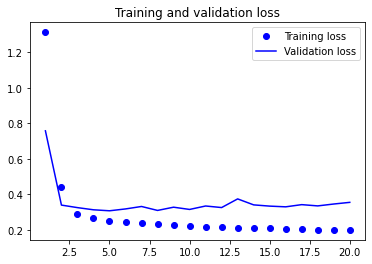

In [51]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. Your common sense contains a lot of valuable information that a machine-learning model doesn’t have access to.

You may wonder, if a simple, well-performing model exists to go from the data to the targets (the common-sense baseline), why doesn’t the model you’re training find it and improve on it? Because this simple solution isn’t what your training setup is looking for. The space of models in which you’re searching for a solution—that is, your hypothesis space—is the space of all possible two-layer networks with the configuration
you defined. These networks are already fairly complicated. When you’re looking for a solution with a space of complicated models, the simple, well-performing baseline may be unlearnable, even if it’s technically part of the hypothesis space. That is a pretty significant limitation of machine learning in general: unless the learning algorithm is hardcoded to look for a specific kind of simple model, parameter learning can sometimes
fail to find a simple solution to a simple problem.

### STEP 5. RNN network with Gated Recurrent Unit (GRU) 

The first fully connected approach didn’t do well, but that doesn’t mean machine learning isn’t applicable to this problem. The previous approach first flattened the timeseries, which removed the notion of time from the input data. Let’s instead look at the data as what it is: a sequence, where causality and order matter. You’ll try a
recurrent-sequence processing model—it should be the perfect fit for such sequence data, precisely because it exploits the temporal ordering of data points, unlike the first approach.

Instead of the LSTM layer introduced in the previous section, you’ll use the GRU layer, developed by Chung et al. in 2014 (comparison using the figure below). 5 Gated recurrent unit (GRU) layers work using the same principle as LSTM, but they’re somewhat streamlined and thus cheaper to run (although they may not have as much representational power as
LSTM). This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.  Note the dot in our previous figure is the $\times$ here.



<img src="RNN_LSTMvsGRU.jpeg" width="700">

### Training and Evaluating a GRU based model

In [ ]:
float_data.shape


In [56]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                6016      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [60]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=10,
                                validation_data=val_gen,
                                validation_steps=1000)

Epoch 1/10
500/500 [==============================] - 49s 99ms/step - loss: 0.2639 - val_loss: 0.2727
Epoch 2/10
500/500 [==============================] - 48s 96ms/step - loss: 0.2553 - val_loss: 0.2764
Epoch 3/10
500/500 [==============================] - 49s 99ms/step - loss: 0.2470 - val_loss: 0.2884
Epoch 4/10
500/500 [==============================] - 49s 98ms/step - loss: 0.2383 - val_loss: 0.2859
Epoch 5/10
500/500 [==============================] - 50s 99ms/step - loss: 0.2309 - val_loss: 0.2924
Epoch 6/10
500/500 [==============================] - 49s 98ms/step - loss: 0.2254 - val_loss: 0.2947
Epoch 7/10
500/500 [==============================] - 49s 98ms/step - loss: 0.2198 - val_loss: 0.3023
Epoch 8/10
500/500 [==============================] - 48s 97ms/step - loss: 0.2151 - val_loss: 0.2987
Epoch 9/10
500/500 [==============================] - 49s 98ms/step - loss: 0.2100 - val_loss: 0.3009
Epoch 10/10
500/500 [==============================] - 51s 101ms/step - loss: 0.20

### Here is now a GRU implementation

In [61]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4608      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=10,
                                validation_data=val_gen,
                                validation_steps=1000)

Epoch 1/10
500/500 [==============================] - 48s 97ms/step - loss: 0.2997 - val_loss: 0.2686
Epoch 2/10
500/500 [==============================] - 48s 96ms/step - loss: 0.2849 - val_loss: 0.2743
Epoch 3/10
500/500 [==============================] - 48s 96ms/step - loss: 0.2763 - val_loss: 0.2641
Epoch 4/10
500/500 [==============================] - 48s 96ms/step - loss: 0.2705 - val_loss: 0.2677
Epoch 5/10
500/500 [==============================] - 47s 95ms/step - loss: 0.2650 - val_loss: 0.2627
Epoch 6/10
500/500 [==============================] - 47s 94ms/step - loss: 0.2606 - val_loss: 0.2641
Epoch 7/10
500/500 [==============================] - 47s 93ms/step - loss: 0.2573 - val_loss: 0.2683
Epoch 8/10
500/500 [==============================] - 47s 94ms/step - loss: 0.2515 - val_loss: 0.2583
Epoch 9/10
500/500 [==============================] - 47s 93ms/step - loss: 0.2471 - val_loss: 0.2735
Epoch 10/10
500/500 [==============================] - 46s 93ms/step - loss: 0.243

In [64]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4608      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


Plot below shows the results. Much better! The new validation MAE of ~0.258 (before you start significantly overfitting) translates to a mean absolute error of 2.35°C after denormalization. That’s a solid gain on the initial error of 2.57°C. You can significantly beat the commonsense baseline, demonstrating the value of machine learning as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

BUT you probably still have a bit of a margin for improvement.

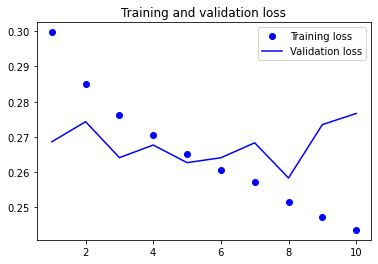

In [65]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### STEP 6. Using recurrent dropout to fight overfitting

It’s evident from the training and validation curves that the model is overfitting: the training and validation losses start to diverge considerably after a few epochs. You’re already familiar with a classic technique for fighting this phenomenon: dropout, which randomly zeros out input units of a layer in order to break incidental correlations in the training data that the layer is exposed to. But how to correctly apply dropout in recurrent networks isn’t a trivial question. It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep.

What’s more, in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers (see Figure 1 below from https://becominghuman.ai/learning-note-dropout-in-recurrent-networks-part-1-57a9c19a2307). Every recurrent layer in Keras has two dropout-related arguments: dropout, a float specifying the dropout rate for input units of the layer, and recurrent_dropout, specifying the dropout rate of the recurrent units. Let’s add
dropout and recurrent dropout to the GRU layer and see how doing so impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, you’ll train the network for twice as many epochs.


<img src="dropouts.png" width="700">

In [66]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [67]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4608      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [101]:
# Training and evaluating a dropout-regularized GRU-based model

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=40,
                            validation_data=val_gen,
                            validation_steps=1000)

Epoch 1/40
500/500 [==============================] - 81s 161ms/step - loss: 0.3280 - val_loss: 0.2798
Epoch 2/40
500/500 [==============================] - 80s 161ms/step - loss: 0.3067 - val_loss: 0.2802
Epoch 3/40
500/500 [==============================] - 80s 160ms/step - loss: 0.2996 - val_loss: 0.2960
Epoch 4/40
500/500 [==============================] - 80s 160ms/step - loss: 0.2941 - val_loss: 0.2684
Epoch 5/40
500/500 [==============================] - 80s 160ms/step - loss: 0.2903 - val_loss: 0.2694
Epoch 6/40
500/500 [==============================] - 80s 160ms/step - loss: 0.2878 - val_loss: 0.2708
Epoch 7/40
500/500 [==============================] - 80s 159ms/step - loss: 0.2813 - val_loss: 0.2697
Epoch 8/40
500/500 [==============================] - 80s 159ms/step - loss: 0.2779 - val_loss: 0.2666
Epoch 9/40
500/500 [==============================] - 80s 159ms/step - loss: 0.2736 - val_loss: 0.2712
Epoch 10/40
500/500 [==============================] - 80s 160ms/step - l

Figure below shows the results. You’re no longer overfitting during the first 10-11 epochs but your best scores aren’t too different they were previously.

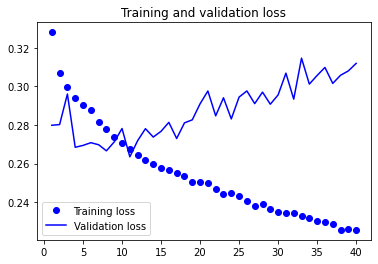

In [102]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Step 7. Stacking recurrent layers

Because you’re no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity of the network. Recall the description of the universal machine-learning workflow: it’s generally a good idea to increase the capacity of your network until overfitting becomes the primary obstacle (assuming you’re already taking basic steps to mitigate overfitting, such as using dropout). As long as you aren’t overfitting too badly, you’re likely under capacity.    

Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks: for instance, what currently powers the Google to translate algorithm is a stack of seven large LSTM layers—that’s huge.   

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying return_sequences=True.

In [70]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))

In [71]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 32)          4608      
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 23,489
Trainable params: 23,489
Non-trainable params: 0
_________________________________________________________________


In [72]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=1000)

Epoch 1/20
500/500 [==============================] - 181s 361ms/step - loss: 0.3178 - val_loss: 0.2765
Epoch 2/20
500/500 [==============================] - 178s 357ms/step - loss: 0.3014 - val_loss: 0.2703
Epoch 3/20
500/500 [==============================] - 179s 357ms/step - loss: 0.2950 - val_loss: 0.2768
Epoch 4/20
500/500 [==============================] - 178s 357ms/step - loss: 0.2892 - val_loss: 0.2680
Epoch 5/20
500/500 [==============================] - 178s 356ms/step - loss: 0.2801 - val_loss: 0.2702
Epoch 6/20
500/500 [==============================] - 178s 356ms/step - loss: 0.2756 - val_loss: 0.2894
Epoch 7/20
500/500 [==============================] - 178s 356ms/step - loss: 0.2700 - val_loss: 0.2839
Epoch 8/20
500/500 [==============================] - 178s 356ms/step - loss: 0.2655 - val_loss: 0.2714
Epoch 9/20
500/500 [==============================] - 178s 355ms/step - loss: 0.2612 - val_loss: 0.2820
Epoch 10/20
500/500 [==============================] - 178s 355m

Figure below shows the results. You can see that the added layer does improve the results a bit, though not significantly. You can draw two conclusions:   

 Because you’re still not overfitting too badly, you could safely increase the size of your layers in a quest for validation-loss improvement. This has a non-negligible computational cost, though.   

 Adding a layer didn’t help by a significant factor, so you may be seeing diminishing returns from increasing network capacity at this point.    

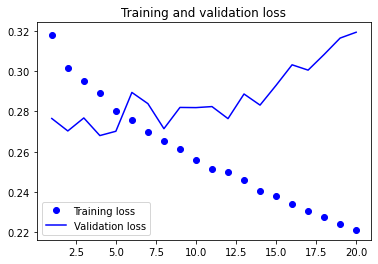

In [73]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Step 8. Never Stop Dreaming! Going even further!

There are many other things you could try, in order to improve performance on the temperature-forecasting problem:

 Adjust the number of units in each recurrent layer in the stacked setup. The current choices are largely arbitrary and thus probably suboptimal.    
  
 Adjust the learning rate used by the RMSprop optimizer.    
  
 Try using LSTM layer then a GRU layer then an LSTM layer again?    
  
 Try using a bigger densely connected regressor on top of the recurrent layers: that is, a bigger Dense layer or even a stack of Dense layers.    
  
 Don’t forget to eventually run the best-performing models (in terms of validation MAE) on the test set! Otherwise, you’ll develop architectures that are overfitting to the validation set. 


Deep learning right now is more an art than a science. We can provide guidelines that suggest what is likely to work or not work on a given problem, but, ultimately, every problem is unique; you’ll have to evaluate different strategies empirically. There is currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must iterate.

### Main Lessons

Here’s what you should take away:

 When approaching a new problem, it’s good to first establish common-sense baselines for your metric of choice. If you don’t have a baseline to beat, you can’t tell whether you’re making real progress.   

 Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.    

 When you have data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal data.    

 To use dropout with recurrent networks, you should use a time-constant dropout mask and recurrent dropout mask. These are built into Keras recurrent layers, so all you have to do is use the dropout and recurrent_dropout arguments of recurrent layers.      

 Stacked RNNs provide more representational power than a single RNN layer. They’re also much more expensive and thus not always worth it. Although they offer clear gains on complex problems (such as machine translation), they may not always be relevant to smaller, simpler problems.  



## Appendix 1. Checkpoint for validation

https://machinelearningmastery.com/check-point-deep-learning-models-keras/

A good use of checkpointing is to output the model weights each time an improvement is observed during training.

The example below creates a small neural network for the Pima Indians onset of diabetes binary classification problem. The example assume that the pima-indians-diabetes.csv file is in your working directory. You can download this dataset from the UCI machine learning repository (update: download from here). The example uses 33% of the data for validation.

Checkpointing is setup to save the network weights only when there is an improvement in classification accuracy on the validation dataset (monitor=’val_acc’ and mode=’max’). 

**The weights are stored in a file that includes the score in the filename (weights-improvement-{val_acc=.2f}.hdf5).**

In [74]:
# Checkpoint the weights when validation accuracy improves
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.data.csv", delimiter=",")

# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# checkpoint

filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5" #Save the Improve model here
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=20, batch_size=10, callbacks=callbacks_list, verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.67323, saving model to weights-improvement-01-0.67.hdf5

Epoch 00002: val_accuracy did not improve from 0.67323

Epoch 00003: val_accuracy did not improve from 0.67323

Epoch 00004: val_accuracy did not improve from 0.67323

Epoch 00005: val_accuracy improved from 0.67323 to 0.67717, saving model to weights-improvement-05-0.68.hdf5

Epoch 00006: val_accuracy improved from 0.67717 to 0.68110, saving model to weights-improvement-06-0.68.hdf5

Epoch 00007: val_accuracy improved from 0.68110 to 0.69685, saving model to weights-improvement-07-0.70.hdf5

Epoch 00008: val_accuracy improved from 0.69685 to 0.70079, saving model to weights-improvement-08-0.70.hdf5

Epoch 00009: val_accuracy did not improve from 0.70079

Epoch 00010: val_accuracy did not improve from 0.70079

Epoch 00011: val_accuracy did not improve from 0.70079

Epoch 00012: val_accuracy did not improve from 0.70079

Epoch 00013: val_accuracy did not improve from 0.70079

Epoc

### Checkpoint Best Neural Network Model Only

A simpler check-point strategy is to save the model weights to the same file, if and only if the validation accuracy improves. This can be done easily using the same code from above and changing the output filename to be fixed (not include score or epoch information).

In this case, model weights are written to the file “weights.best.hdf5” only if the classification accuracy of the model on the validation dataset improves over the best seen so far.

In [75]:
# Checkpoint the weights for best model on validation accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.data.csv", delimiter=",")
# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
# Fit the model
model.fit(X, Y, validation_split=0.33, epochs=20, batch_size=10, callbacks=callbacks_list, verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.67323, saving model to weights.best.hdf5

Epoch 00002: val_accuracy did not improve from 0.67323

Epoch 00003: val_accuracy did not improve from 0.67323

Epoch 00004: val_accuracy improved from 0.67323 to 0.68898, saving model to weights.best.hdf5

Epoch 00005: val_accuracy did not improve from 0.68898

Epoch 00006: val_accuracy did not improve from 0.68898

Epoch 00007: val_accuracy did not improve from 0.68898

Epoch 00008: val_accuracy did not improve from 0.68898

Epoch 00009: val_accuracy did not improve from 0.68898

Epoch 00010: val_accuracy improved from 0.68898 to 0.69291, saving model to weights.best.hdf5

Epoch 00011: val_accuracy did not improve from 0.69291

Epoch 00012: val_accuracy did not improve from 0.69291

Epoch 00013: val_accuracy did not improve from 0.69291

Epoch 00014: val_accuracy did not improve from 0.69291

Epoch 00015: val_accuracy did not improve from 0.69291

Epoch 00016: val_accuracy did not improve fro

You should see the weight file in your local directory: "weights.best.hdf5"

### Loading a Check-Pointed Neural Network Model

Now that you have seen how to checkpoint your deep learning models during training, you need to review how to load and use a checkpointed model.The checkpoint only includes the model weights. It assumes you know the network structure. 

In the example below, the model structure is known and the best weights are loaded from the previous experiment, stored in the working directory in the weights.best.hdf5 file.

The model is then used to make predictions on the entire dataset.

In [76]:
# How to load and use weights from a checkpoint

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# create model
model = Sequential()
model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

# load weights
model.load_weights("weights.best.hdf5")
# Compile model (required to make predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Created model and loaded weights from file")

# load pima indians dataset
dataset = numpy.loadtxt("pima-indians-diabetes.data.csv", delimiter=",")

# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

# estimate accuracy on whole dataset using loaded weights
scores = model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Created model and loaded weights from file
accuracy: 68.23%


### Let's Visualize the results
First, let's consider the dropout-regularized GRU-based model

In [77]:
# Training and evaluating a dropout-regularized GRU-based model

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.1,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [78]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 32)                4608      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Training and evaluating a dropout-regularized GRU-based model

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.1,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=4,
                            validation_data=val_gen,
                            validation_steps=1000)

Epoch 1/4
500/500 [==============================] - 79s 158ms/step - loss: 0.3302 - val_loss: 0.2745
Epoch 2/4
500/500 [==============================] - 79s 158ms/step - loss: 0.3045 - val_loss: 0.2759
Epoch 3/4
500/500 [==============================] - 79s 158ms/step - loss: 0.2980 - val_loss: 0.2759
Epoch 4/4
500/500 [==============================] - 79s 158ms/step - loss: 0.2943 - val_loss: 0.2678


For purpose of speed let's look at just the first 1000 training, validation and test data

In [80]:
traing = []
for i in range(1000):
    traing.append(next(train_gen))

vg = []
for i in range(1000):
    vg.append(next(val_gen))
    
testg = []
for i in range(1000):
    testg.append(next(test_gen))

### Familiarizing with inputs, outputs of the NN

In [81]:
vg[0][0].shape #inputs sample_number or batch_size, input_timedelay, number_variables

(128, 240, 14)

In [82]:
vg[999][0].shape #v[validation steps][input or target]

(128, 240, 14)

In [83]:
vg[999][1].shape #target

(128,)

In [84]:
float_data.shape  ## total lines with 14 parameters

(420551, 14)

### Predict ~ 2 days

In [85]:
pred1 = model.predict(vg[0][0]) #predict first 1280 minutes or 21.33 days 
pred2= model.predict(vg[1][0]) #predict inputs of next 1280 mins
pred3= model.predict(vg[2][0]) #predict inputs of next 1280* 3
pred4= model.predict(vg[3][0]) #predict inputs of next 1280* 4
pred5= model.predict(vg[4][0]) #predict inputs of next 1280* 5
pred6= model.predict(vg[5][0]) #predict inputs of next 1280* 6
pred10= model.predict(vg[9][0]) #predict inputs of next 1280* 9
pred1000= model.predict(vg[999][0]) #predict inputs of next 1280* 1000

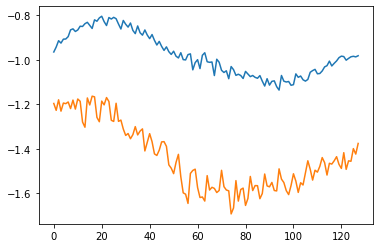

In [86]:
plt.plot(pred2)

plt.plot(pred10)

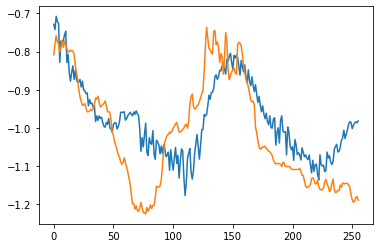

In [87]:
plt.plot(np.append(pred1, pred2))
plt.plot(np.append(vg[0][1], vg[1][1]))

### Predict ~9 days

In [88]:
preds = np.array([])
targets = np.array([])
for v in vg[:10]:
    preds = np.append(preds, model.predict(v[0]))
    targets = np.append(targets, v[1])

In [89]:
preds_train = np.array([])
targets_train = np.array([])
for v in traing[:10]:
    preds_train = np.append(preds_train, model.predict(v[0]))
    targets_train = np.append(targets_train, v[1])
    
preds_test = np.array([])
targets_test = np.array([])
for v in testg[:10]:
    preds_test = np.append(preds_test, model.predict(v[0]))
    targets_test = np.append(targets_test, v[1])

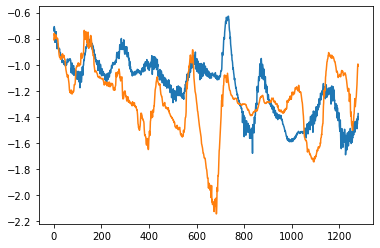

In [90]:
plt.plot(preds)
plt.plot(targets)

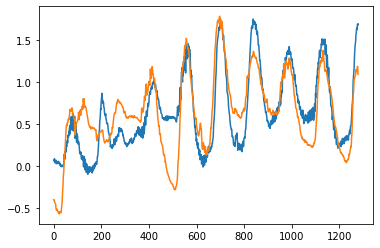

In [91]:
plt.plot(preds_test)
plt.plot(targets_test)